In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
import time
import os

In [2]:
# Commonly changed settings

new_rig_settings = True
datadir = "./tsm_targets/05-31-22" # All files in this directory + subdirectories are loaded
if new_rig_settings:
    datadir = None # auto selects "C:/Turbo-SM/SMDATA/John/mm-dd-yy" on new rig
n_group_by_trials = 5 # Treats every n selected files as trials to combine into single ZDA file

c = Controller(camera_program=4,
              new_rig_settings=new_rig_settings,
              should_auto_launch=True,  # set to False as a safety to avoid double-launch
              datadir=datadir)
print("Data exchange directory:", c.get_data_dir())

Data exchange directory: C:/Turbo-SM/SMDATA/John/06-13-22


In [7]:
c.start_up() # launch and orchestrate
slice_no = 1
location_no = 1
recording_no = 10
detection_loops = 1

In [6]:
# auto mode: TSM scheduling
c = Controller(camera_program=4,
              new_rig_settings=new_rig_settings,
              should_auto_launch=False,
              datadir=datadir,  
              filename_PhotoZ_format=True)  # SS_LL_RR.zda naming
c.run_recording_schedule()  # default: takes 5 trials at 15-s intervals

New file detected: Untitled046.tsm
New file detected: Untitled047.tsm
New file detected: Untitled048.tsm
New file detected: Untitled049.tsm
New file detected: Untitled050.tsm
Preparing to process into ZDA file(s)... 
C:/Turbo-SM/SMDATA/John/06-13-22/Untitled046.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
C:/Turbo-SM/SMDATA/John/06-13-22/Untitled047.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
C:/Turbo-SM/SMDATA/John/06-13-22/Untitled048.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160

TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
C:/Turbo-SM/SMDATA/John/06-13-22\1_1/Untitled026.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
C:/Turbo-SM/SMDATA/John/06-13-22\1_1/Untitled027.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
C:/Turbo-SM/SMDATA/John/06-13-22\1_1/Untitled028.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN 

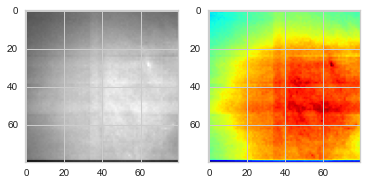

(1, 199, 80, 80)


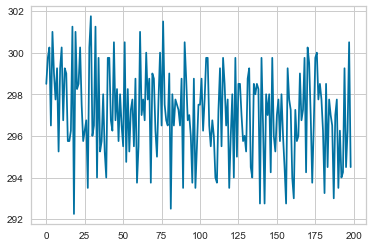

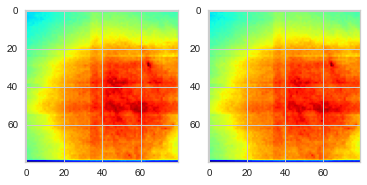

(1, 8, 199)
trial group 0
	 C:/Turbo-SM/SMDATA/John/06-13-22/Untitled046.tsm
	 C:/Turbo-SM/SMDATA/John/06-13-22/Untitled047.tsm
	 C:/Turbo-SM/SMDATA/John/06-13-22/Untitled048.tsm
	 C:/Turbo-SM/SMDATA/John/06-13-22/Untitled049.tsm
	 C:/Turbo-SM/SMDATA/John/06-13-22/Untitled050.tsm
# of trial-grouped datasets: 1
Not all DLL search paths added.
(5, 8, 199)
Written to 01_01_10.zda
Next recording_no: 11
[]


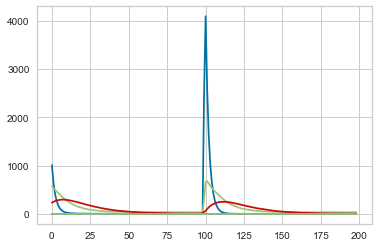

In [8]:
new_files = []
# archive directory
dst_dir = c.get_data_dir() + "/" + str(slice_no) + "_" + str(location_no)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
fd = FileDetector(directory=c.get_data_dir())
for i in range(detection_loops):
    time.sleep(3)
    fd.detect_files()
    new_files += fd.get_unprocessed_file_list()
    if len(new_files) >= n_group_by_trials:
        new_files.sort()
        print("Preparing to process into ZDA file(s)... ")
        time.sleep(5)  # wait for TurboSM to safely finish writing to disk
        
        # process new files
        n_process = len(new_files) - (len(new_files) % n_group_by_trials)
        c.select_files(selected_filenames=new_files[:n_process],
                       slice_no=slice_no,
                       location_no=location_no,
                       recording_no=recording_no)
        c.process_files(n_group_by_trials=n_group_by_trials)
        recording_no += int(len(new_files) / n_group_by_trials)
        
        # auto-archive processed files by moving them to a directory 'slice-loc'
        for pro_file in new_files[:n_process]:
            stripped_file = pro_file.split("/")[-1]
            dst_file = dst_dir + "/" + stripped_file
            os.rename(pro_file, dst_file)
            # tbn file
            os.rename(pro_file[:-4] + ".tbn", dst_file[:-4] + ".tbn")

        
        new_files = new_files[n_process:]
    print("Next recording_no:", recording_no)
    print(new_files)


In [ ]:
# manual mode example: processing only
""" c.select_files(slice_no=3, 
                   location_no=1,
                   recording_no=1, 
                   filename_base="3-1-",
                   filename_start_no=1,
                   filename_end_no=25)
c.process_files(n_group_by_trials=n_group_by_trials) """

# 